In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import warnings
import plotly.express as px 
from plotly.subplots import make_subplots
import plotly.graph_objects as go
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import plotly.express as px 
sys.path.insert(1, "../src/utils/")
from agent import Environment
from Q_learning import QLearningTrainer
sys.path.insert(1, "plotly_graph/")
from functions4tuto import plotly_trajectory, control_fall_simulation, booster_reward, plotly_all_reward
JOSN_file = "rocket_tuto_2 copy.json"

# <span style="color:orange">Intialize environment</span>

Create an environment object with the rules defined previously. The idea is to check the new field can raise a flag to stop simulation when the criteria are reached:

* 0 <= pos_y >= 10
* -2 <= acceleration_y >= 2
* -10 <= speed_y >= 10 


In [2]:
# Create an environment object with the rules defined previously
env = Environment(JOSN_file, check_model = True)

check order names for states_variables
state_variables : speed_y, initial_value: acceleration_y, limit: acceleration_y
state_variables : weight_rocket, initial_value: speed_y, limit: speed_y

Check order names for agent_variables

check limit number of field

Check limit boundaries for initial state

Solve equations present in equations_variables field

Solve equations present in equations_rewards field

Everything is good :)


In [6]:
env.lower_lim

array([  0., -50.,   5.,   0.])

In [3]:
env.states_variables

['pos_y', 'speed_y', 'weight_rocket']

In [5]:
syst_dic = env.json

In [7]:
delimiter="$"
initial_system = {tmpkey.replace(delimiter, ''): value for tmpkey, value in syst_dic["initial_values"].items()}
start_pos = {key: value for key, value in initial_system.items() if key in env.states_variables + env.agent_variables}

In [8]:
initial_system

{'pos_y': [175.0],
 'acceleration_y': [0.0],
 'speed_y': [0.0],
 'booster': [0.0],
 'angle': [0.0],
 'alpha': [0.0],
 'm_fuel': [100],
 'futur_pos_y': [175.0],
 'weight_rocket': [105],
 'weight_dry_rocket': [5],
 'G': [1.62],
 'm_fuel_ini': [100.0],
 'pos_y_star': [0.0],
 'pos_y_ini': [175.0]}

In [9]:
env.upper_lim

array([200.,  50.,   1., 105.])

In [12]:
np.array([list(syst_dic['limit'][key])[0] for key in env.states_variables + env.agent_variables if key in syst_dic['limit']]).flatten()


array([  0., -50.,   5.,   0.])

In [39]:
{key: list(initial_system[key]) for key in env.states_variables + env.agent_variables if key in initial_system.keys()}

{'pos_y': [175.0], 'speed_y': [0.0], 'weight_rocket': [105], 'booster': [0.0]}

In [31]:
np.array([np.round(initial_system[key],6) for key in env.states_variables + env.agent_variables if key in initial_system]).flatten()

array([175.,   0., 105.,   0.])

In [34]:
{key: value for key, value in initial_system.items() if key in env.states_variables + env.agent_variables}

{'pos_y': [175.0], 'speed_y': [0.0], 'booster': [0.0], 'weight_rocket': [105]}

In [17]:
initial_system.items()

dict_items([('pos_y', [175.0]), ('acceleration_y', [0.0]), ('speed_y', [0.0]), ('booster', [0.0]), ('angle', [0.0]), ('alpha', [0.0]), ('m_fuel', [100]), ('futur_pos_y', [175.0]), ('weight_rocket', [105]), ('weight_dry_rocket', [5]), ('G', [1.62]), ('m_fuel_ini', [100.0]), ('pos_y_star', [0.0]), ('pos_y_ini', [175.0])])

In [18]:
{key: list(syst_dic['limit'][key])[0] for key in env.states_variables + env.agent_variables if key in syst_dic['limit']}

{'pos_y': 0.0, 'speed_y': -50.0, 'weight_rocket': 5.0, 'booster': 0.0}

In [8]:
{key : list(val)[0] for key, val in syst_dic['limit'].items() if key in env.states_variables + env.agent_variables}

{'pos_y': 0.0, 'speed_y': -50.0, 'booster': 0.0, 'weight_rocket': 5.0}

In [31]:
{key: list(syst_dic['limit'][key])[0] for key in env.states_variables + env.agent_variables if key in syst_dic['limit']}


{'pos_y': 0.0, 'speed_y': -50.0, 'weight_rocket': 5.0, 'booster': 0.0}

In [11]:
env.current_pos

array([175.,   0.,   0., 105.])

## <span style="color:orange">Reinforcemet learning</span>


After load our environment, next step is to create QLearningTrainer objet. It will apply Qlearning algorithm. For each states, the algorithm will apply a score base to the next iteration.

The Bellman equation is the value function use in reinforcement learning. 

$v(s) = (1−\alpha) * V(s)+ \alpha * (R+\gamma * V(s'))$

Where:

* $V(s)$ is the estimated value of state $s$ * $s$ is the curent state
* $s'$ is the next state.
* $R$ is the immediate reward received after transitioning from state $s$ to state
* $\gamma$ is the discount factor, which determines the importance of future rewards.
* $\alpha$ is the learning rate.
s.l difference (TD) learning methods.

In [3]:
# Load RL object
env = Environment(JOSN_file, check_model = True)
RL = QLearningTrainer(env, num_episodes = 400, convergence_criterion = 0.5, decay_type = "exponential")

check order names for states_variables
state_variables : weight_rocket, initial_value: acceleration_y, limit: acceleration_y

Check order names for agent_variables

check limit number of field

Check limit boundaries for initial state

Solve equations present in equations_variables field

Solve equations present in equations_rewards field

Everything is good :)


Different parameters are avaible. For the tutorial, you use default parameters. Before to lunch training. Lets discus about the input parameters.

### <span style="color:orange">Learning rate</span>


The learning rate $\alpha$ in the Bellman equation controls the weight given to the new estimate compared to the existing estimate of the state value. A smaller learning rate means that the new estimate has less influence, and the agent is more conservative in updating its value function. A larger learning rate allows the agent to adjust its estimates more rapidly based on new information

### <span style="color:orange">Discount factor ($\gamma$)</span>


### <span style="color:orange">Epsilon parameter</span>

Exploration-exploitation is a fundamental trade-off in reinforcement learning, where the agent needs to balance between exploring new actions and exploiting the knowledge it has gained so far.

The epsilon-greedy policy is a simple strategy that the agent uses to decide whether to explore a new action (random exploration) or exploit the current best-known action. It helps prevent the agent from getting stuck in suboptimal policies by occasionally trying new actions. The value of epsilon determines the probabilty the agent chooses a random action. A higher epsilon encourages more exploration, while a lower epsilon emphasizes exploitation of the current best-known actions.ent knowledge.

The epsilon parameter is decayed over time during training. This means that, as the agent gains more experience, it tends to rely more on exploitation and less on exploration. The idea is that, as the agent learns and becomes more confident in its estimates, it gradually reduces the rate of exploration. 

Epsilon initailization is made with the argument **exploration_prob**. It is a list with the lowest and the highest probability values. The probability will decrease with a rate given by the argument **decrease_prob_exp**. By default epsilon is modeled with a linear decay but you can change it to a exponential decay.


In [4]:
RL.q_learning()

Episode 1/400
exploration_prob : 1.000
current_state :  ([np.float64(175.0)], [np.float64(0.0)], [np.float64(105.0)])
level0_col :  booster
current_q_value :  0
next_max_q_value :  [-175.405]
updated_q :  [-34.905595]
current_state :  ([np.float64(175.0)], [np.float64(-1.0)], [np.float64(105.0)])
level0_col :  booster
current_q_value :  0
next_max_q_value :  [-174.64285714]
updated_q :  [-34.723]
current_state :  ([np.float64(174.0)], [np.float64(0.0)], [np.float64(100.0)])
level0_col :  booster
current_q_value :  0.0
next_max_q_value :  [-174.54714286]
updated_q :  [-34.74445286]
current_state :  ([np.float64(174.0)], [np.float64(-1.0)], [np.float64(100.0)])
level0_col :  booster
current_q_value :  0.0
next_max_q_value :  [-174.04642857]
updated_q :  [-34.68531071]
current_state :  ([np.float64(173.0)], [np.float64(-2.0)], [np.float64(100.0)])
level0_col :  booster
current_q_value :  0.0
next_max_q_value :  [-173.14071429]
updated_q :  [-34.54557357]
current_state :  ([np.float64(171.

In [5]:
tmp = RL.q_table.copy().reset_index()

In [10]:
RL.q_table

booster              \
                                                          (0,)        (1,)   
([np.float64(175.0)], [np.float64(0.0)], [np.fl... -550.592671 -550.498575   
([np.float64(175.0)], [np.float64(-1.0)], [np.f... -391.357078 -392.830357   
([np.float64(174.0)], [np.float64(0.0)], [np.fl... -259.695515 -253.669107   
([np.float64(174.0)], [np.float64(-1.0)], [np.f... -187.534672 -192.869849   
([np.float64(173.0)], [np.float64(-2.0)], [np.f...  -93.635058 -110.256471   
...                                                        ...         ...   
([np.float64(197.0)], [np.float64(9.0)], [np.fl...  -42.037633    0.000000   
([np.float64(199.0)], [np.float64(17.0)], [np.f...  -45.116770    0.000000   
([np.float64(175.0)], [np.float64(6.0)], [np.fl...  -37.233566    0.000000   
([np.float64(182.0)], [np.float64(4.0)], [np.fl...  -37.498910    0.000000   
([np.float64(197.0)], [np.float64(13.0)], [np.f...  -43.348632    0.000000   

                                                                
                                                          (2,)  
([np.float64(175.0)], [np.float64(0.0)], [np.fl... -549.678401  
([np.float64(175.0)], [np.float64(-1.0)], [np.f... -390.733660  
([np.float64(174.0)], [np.float64(0.0)], [np.fl... -254.371046  
([np.float64(174.0)], [np.float64(-1.0)], [np.f... -192.935997  
([np.float64(173.0)], [np.float64(-2.0)], [np.f... -103.280669  
...                                                        ...  
([np.float64(197.0)], [np.float64(9.0)], [np.fl...    0.000000  
([np.float64(199.0)], [np.float64(17.0)], [np.f...    0.000000  
([np.float64(175.0)], [np.float64(6.0)], [np.fl...    0.000000  
([np.float64(182.0)], [np.float64(4.0)], [np.fl...    0.000000  
([np.float64(197.0)], [np.float64(13.0)], [np.f...    0.000000  

[3215 rows x 3 columns]

In [6]:
tmp

index     booster  \
                                                               (0,)   
0     ([np.float64(175.0)], [np.float64(0.0)], [np.f... -550.592671   
1     ([np.float64(175.0)], [np.float64(-1.0)], [np.... -391.357078   
2     ([np.float64(174.0)], [np.float64(0.0)], [np.f... -259.695515   
3     ([np.float64(174.0)], [np.float64(-1.0)], [np.... -187.534672   
4     ([np.float64(173.0)], [np.float64(-2.0)], [np....  -93.635058   
...                                                 ...         ...   
3210  ([np.float64(197.0)], [np.float64(9.0)], [np.f...  -42.037633   
3211  ([np.float64(199.0)], [np.float64(17.0)], [np....  -45.116770   
3212  ([np.float64(175.0)], [np.float64(6.0)], [np.f...  -37.233566   
3213  ([np.float64(182.0)], [np.float64(4.0)], [np.f...  -37.498910   
3214  ([np.float64(197.0)], [np.float64(13.0)], [np....  -43.348632   

                              
            (1,)        (2,)  
0    -550.498575 -549.678401  
1    -392.830357 -390.733660  
2    -253.669107 -254.371046  
3    -192.869849 -192.935997  
4    -110.256471 -103.280669  
...          ...         ...  
3210    0.000000    0.000000  
3211    0.000000    0.000000  
3212    0.000000    0.000000  
3213    0.000000    0.000000  
3214    0.000000    0.000000  

[3215 rows x 4 columns]

In [15]:
tmp['index'] = tmp['index'].str.replace(r"[()\[\]]", "", regex=True)
# Split the 'index' column into multiple columns
tmp[["pos_y", "weight_rocket", "speed_y"]] = tmp['index'].str.split(",", expand=True)
tmp = tmp.drop(columns=['index'])


/tmp/ipykernel_6321/107971909.py:4: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



In [16]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None
tmp = tmp.sort_values(by=["pos_y", "weight_rocket", "speed_y"], ascending=[True, True])

tmp

ValueError: Length of ascending (2) != length of by (3)

In [ ]:
tmp.reset_index()
tmp['index'].str.replace(r"[()\[\]]", "", regex=True)

KeyError: 'index'

In [ ]:
RL.env.rewards

{'booster': array([-175.        , -174.595     , -173.785     , -173.32      ,
        -174.03333333, -176.1125    , -178.72416667, -182.0022619 ,
        -185.94678571, -190.73630952, -197.87083333, -206.93369048])}

In [ ]:
pd.DataFrame(RL.env.all_states())

,pos_y,acceleration_y,speed_y,booster,angle,alpha,m_fuel,futur_pos_y,weight_rocket,weight_dry_rocket,G,m_fuel_ini,pos_y_star,pos_y_ini
0,175.000000,0.000000,0.000000,0.0,0.0,0.0,100.0,175.000000,105.0,5,1.62,100.0,0.0,175.0
1,174.595000,-1.620000,-0.810000,0.0,0.0,0.0,100.0,172.165000,105.0,5,1.62,100.0,0.0,175.0
2,173.785000,-1.620000,-1.620000,0.0,0.0,0.0,100.0,168.925000,105.0,5,1.62,100.0,0.0,175.0
3,173.320000,4.380000,0.570000,1.0,0.0,0.0,90.0,175.030000,95.0,5,1.62,100.0,0.0,175.0
4,174.033333,5.046667,3.093333,1.0,0.0,0.0,80.0,183.313333,85.0,5,1.62,100.0,0.0,175.0
5,176.112500,5.880000,6.033333,1.0,0.0,0.0,70.0,194.212500,75.0,5,1.62,100.0,0.0,175.0
6,178.724167,-1.620000,5.223333,0.0,0.0,0.0,70.0,194.394167,75.0,5,1.62,100.0,0.0,175.0
7,182.002262,6.951429,8.699048,1.0,0.0,0.0,60.0,208.099405,65.0,5,1.62,100.0,0.0,175.0
8,185.946786,-1.620000,7.889048,0.0,0.0,0.0,60.0,209.613929,65.0,5,1.62,100.0,0.0,175.0
9,190.736310,8.380000,12.079048,1.0,0.0,0.0,50.0,226.973452,55.0,5,1.62,100.0,0.0,175.0


# Test debugage

In [ ]:
# env = Environment(JOSN_file, check_model = False)
# RL = QLearningTrainer(env, num_episodes = 800, convergence_criterion = 0.5, decay_type = "exponential")
# RL.env.agent_variables

In [ ]:
env = Environment(JOSN_file, check_model = False)
RL = QLearningTrainer(env, num_episodes = 800, convergence_criterion = 0.5, decay_type = "exponential")
while RL.env.all_states()["futur_pos_y"][-1] > 20:
    actions = RL.call_choose_action(RL.env.state_for_q_table(), 1)
    actions = ["0"]
    next_env, rewards, done, problem, info = RL.env.step(actions, RL.env.agent_variables)

while RL.env.all_states()["speed_y"][-1] < 0:
    next_env, rewards, done, problem, info = RL.env.step(["2"], RL.env.agent_variables)

while RL.env.all_states()["pos_y"][-1] > 10:
    actions = RL.call_choose_action(RL.env.state_for_q_table(), 1)
    actions = ["0"]
    next_env, rewards, done, problem, info = RL.env.step(actions, RL.env.agent_variables)

stop episode because agent reach goal


In [ ]:
done

[True]

In [ ]:
RL.env.all_states(["pos_y", 'speed_y', "rewards"])

{'pos_y': array([175.        , 174.595     , 173.785     , 172.57      ,
        170.95      , 168.925     , 166.495     , 163.66      ,
        160.42      , 156.775     , 152.725     , 148.27      ,
        143.41      , 138.145     , 132.475     , 126.4       ,
        119.92      , 113.035     , 105.745     ,  98.05      ,
         89.95      ,  81.445     ,  72.535     ,  63.97      ,
         56.58333333,  50.5625    ,  46.14559524,  43.64511905,
         43.48964286,  44.42916667,  44.96369048,  45.09321429,
         44.8177381 ,  44.1372619 ,  43.05178571,  41.56130952,
         39.66583333,  37.36535714,  34.65988095,  31.54940476,
         28.03392857,  24.11345238,  19.78797619,  15.0575    ,
          9.92202381]),
 'speed_y': array([  0.        ,  -0.81      ,  -1.62      ,  -2.43      ,
         -3.24      ,  -4.05      ,  -4.86      ,  -5.67      ,
         -6.48      ,  -7.29      ,  -8.1       ,  -8.91      ,
         -9.72      , -10.53      , -11.34      , -12.15    

In [ ]:
np.exp(1) - np.exp( np.max([ np.max( np.abs(RL.env.all_states()["speed_y"] )/17 ), 1 ]) )

-0.13433082287985476

In [ ]:
rew_speed = [np.exp(1) - np.exp( np.max([ np.max( np.abs(speed)/17 ), 1 ]) ) for speed in RL.env.all_states()["speed_y"] ]

In [ ]:
RL.q_table.columns[0]

('booster', ('0',))

In [ ]:
RL.env.all_states()

{'pos_y': array([175.        , 174.595     , 174.14214286, 173.64142857,
        172.73571429, 171.8       , 170.83428571, 169.46357143,
        167.68785714, 166.34047619, 166.35892857, 167.40988095,
        168.55583333, 169.8325    , 172.48988095, 175.9922619 ,
        180.58964286, 187.11535714, 194.06940476, 201.55595238]),
 'acceleration_y': array([ 0.        , -1.62      ,  1.23714286, -1.62      , -1.62      ,
         1.38      , -1.62      , -1.62      , -1.62      ,  5.04666667,
         5.88      ,  2.38      , -1.62      ,  2.66571429,  8.38      ,
        -1.62      , 10.38      ,  5.04666667, -1.62      ,  5.88      ]),
 'speed_y': array([ 0.        , -0.81      , -0.19142857, -1.00142857, -1.81142857,
        -1.12142857, -1.93142857, -2.74142857, -3.55142857, -1.02809524,
         1.91190476,  3.10190476,  2.29190476,  3.6247619 ,  7.8147619 ,
         7.0047619 , 12.1947619 , 14.71809524, 13.90809524, 16.84809524]),
 'booster': array([0. , 0. , 0.5, 0. , 0. , 0.5, 0. 

175.0

In [126]:
RL.env.all_states()["pos_y"]

array([175.])

In [115]:
RL.env.all_states()["speed_y"]

array([  0.  ,  -0.81,  -1.62,  -2.43,  -3.24,  -4.05,  -4.86,  -5.67,
        -6.48,  -7.29,  -8.1 ,  -8.91,  -9.72, -10.53, -11.34, -12.15,
       -12.96, -13.77, -14.58, -15.39, -16.2 , -17.01, -17.82])

In [87]:
stop_episode = [np.isclose(env.last_state()[key][0], value[0]) 
                            if len(value) == 1 
                            else env.last_state()[key][0] >= value[0] and env.last_state()[key][0] <= value[1] 
                            for key, value in env.json["stop_episode"].items()]


In [91]:
any(stop_episode)

True

In [ ]:
stop_episode = [np.isclose(self.last_state()[key][0], value[0]) 
                            if len(value) == 1 
                            else self.last_state()[key][0] >= value[0] and self.last_state()[key][0] <= value[1] 
                            for key, value in self.json["stop_episode"].items()]


['new position is out of bound']

In [43]:
RL.call_choose_action(RL.env.state_for_q_table(), 1)

['2']

In [ ]:
flag = "0"
current_state, rewards, done, problem, info = env.step([flag])

[False]

### <span style="color:orange">num_episodes, run_limit and convergence_criterion</span>

The last three options are hyperparameters. They impact computation time. **num_episodes** is the maximum number of epochs used for training. **run_limit** controls the maximum number of iterations before stopping one episode. **convergence_criterion** is the threshold (difference score between two iterations) to determine convergence.


In [11]:
RL.q_learning()

Episode 1/800
exploration_prob : 1.000
current_state :  ([175.0],)
level0_col :  booster
current_q_value :  0
next_max_q_value :  [-0.99305714]
updated_q :  [-0.19808123]
current_state :  ([175.0],)
level0_col :  booster
current_q_value :  0
next_max_q_value :  [-0.99223673]
updated_q :  [-0.19774123]
current_state :  ([174.0],)
level0_col :  booster
current_q_value :  0.0
next_max_q_value :  [-0.98706122]
updated_q :  [-0.19694273]
current_state :  ([174.0],)
level0_col :  booster
current_q_value :  -0.19694273469387757
next_max_q_value :  [-0.97957143]
updated_q :  [-0.19568369]
current_state :  ([173.0],)
level0_col :  booster
current_q_value :  0
next_max_q_value :  [-0.98330118]
updated_q :  [-0.19575509]
current_state :  ([172.0],)
level0_col :  booster
current_q_value :  0.0
next_max_q_value :  [-0.99533142]
updated_q :  [-0.19737213]
current_state :  ([173.0],)
level0_col :  booster
current_q_value :  -0.19575508764769067
next_max_q_value :  [-1.02374162]
updated_q :  [-0.20145

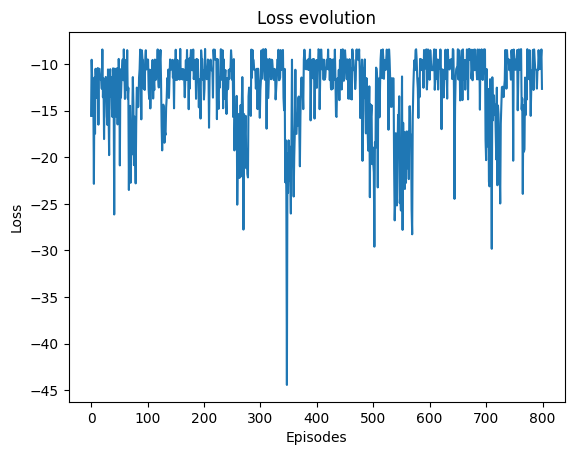

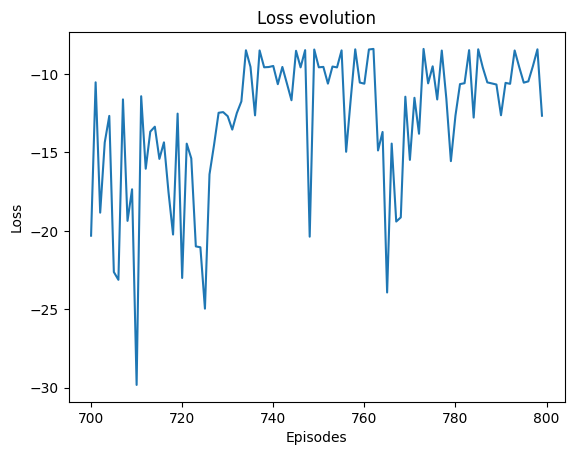

In [ ]:
RL.plot_convergence()
RL.plot_convergence(start = 700)

In [13]:
pd.DataFrame(RL.env.all_states())

,pos_y,acceleration_y,speed_y,booster,angle,alpha,m_fuel,futur_pos_y,weight_rocket,weight_dry_rocket,G,m_fuel_ini,pos_y_star,pos_y_ini
0,175.000000,0.000000,0.000000,0.0,0.0,0.0,100.0,175.000000,105.0,5,1.62,100.0,0.0,175.0
1,175.345000,4.380000,2.190000,1.0,0.0,0.0,90.0,181.915000,95.0,5,1.62,100.0,0.0,175.0
2,176.868333,5.046667,4.713333,1.0,0.0,0.0,80.0,191.008333,85.0,5,1.62,100.0,0.0,175.0
3,178.820000,-1.620000,3.903333,0.0,0.0,0.0,80.0,190.530000,85.0,5,1.62,100.0,0.0,175.0
4,180.366667,-1.620000,3.093333,0.0,0.0,0.0,80.0,189.646667,85.0,5,1.62,100.0,0.0,175.0
5,181.508333,-1.620000,2.283333,0.0,0.0,0.0,80.0,188.358333,85.0,5,1.62,100.0,0.0,175.0
6,182.245000,-1.620000,1.473333,0.0,0.0,0.0,80.0,186.665000,85.0,5,1.62,100.0,0.0,175.0
7,183.514167,5.880000,4.413333,1.0,0.0,0.0,70.0,196.754167,75.0,5,1.62,100.0,0.0,175.0
8,186.387262,6.951429,7.889048,1.0,0.0,0.0,60.0,210.054405,65.0,5,1.62,100.0,0.0,175.0
9,191.176786,8.380000,12.079048,1.0,0.0,0.0,50.0,227.413929,55.0,5,1.62,100.0,0.0,175.0


# <span style="color:orange">Optimal trajectory</span>

Lets see how the rocket evolves after train.

In [11]:
# load policy table
policy = RL.q_table.copy().replace(0, np.nan)
# load environnment
env = Environment(JOSN_file, check_model = False)
state = env.state_for_q_table()
flag_continue = True
while flag_continue:
    # control while loop
    if not policy.index.isin([str(state)]).any():
        flag_continue = False
        print("stop: no moore state")
        continue
    if env.m_fuel[-1] < 0:
        print("stop: no moore fuel")
        env.delete_last_states()
        flag_continue = False
    action = RL.call_choose_action(state, 0)
    _, _, _, _, _ = env.step(action)
    state = env.state_for_q_table()

dt = pd.DataFrame(env.all_states())

d:\projets_git\RL_engine\notebook\next_state_compute.py:14: RuntimeWarning:

divide by zero encountered in divide

d:\projets_git\RL_engine\notebook\next_state_compute.py:15: RuntimeWarning:

divide by zero encountered in divide

d:\projets_git\RL_engine\notebook\next_state_compute.py:16: RuntimeWarning:

divide by zero encountered in divide

d:\projets_git\RL_engine\notebook\next_state_compute.py:33: RuntimeWarning:

invalid value encountered in add



stop: no moore fuel


AttributeError: 'Environment' object has no attribute 'delete_last_state'

In [ ]:
dt